Dữ liệu ban đầu:
                timeStamp  payload_Zone1_humidity_mt0708_dew_value  \
0 2024-07-15 23:56:43.918                                 85.03775   
1 2024-07-15 23:56:48.920                                 84.97577   
2 2024-07-15 23:56:53.939                                 84.91971   
3 2024-07-15 23:56:58.923                                 84.95148   
4 2024-07-15 23:57:03.971                                 84.97528   

   payload_Zone1_humidity_mt0708_pid_out_htr  
0                                  24.221770  
1                                  23.322676  
2                                  25.734009  
3                                  24.551308  
4                                  24.550676  
Dữ liệu sau khi xử lý mean fill:
                timeStamp  payload_Zone1_humidity_mt0708_dew_value  \
0 2024-07-15 23:56:43.918                                 85.03775   
1 2024-07-15 23:56:48.920                                 84.97577   
2 2024-07-15 23:56:53.939            

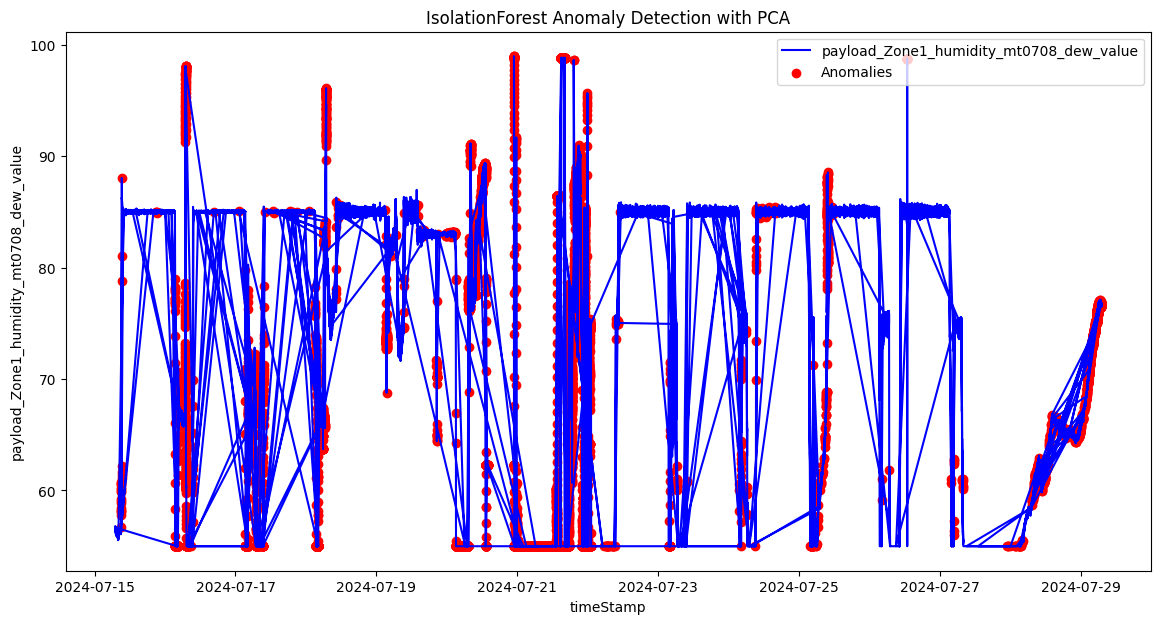

In [9]:
import pandas as pd
from pyspark.sql import SparkSession
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Tạo Spark session
spark = SparkSession.builder.appName("AnomalyDetection").getOrCreate()

# Đọc file CSV
file_path = "../../../data/zone_temparature_and_humidity.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Chuyển đổi DataFrame của Spark thành Pandas DataFrame
pandas_df = df.toPandas()

# Hiển thị dữ liệu ban đầu
print("Dữ liệu ban đầu:")
print(pandas_df.head())

# Lấy danh sách header và bỏ qua cột đầu tiên
columns = pandas_df.columns

# Chọn cột đầu tiên làm trục X (Timestamp) và một cột được chọn làm trục Y
timestamp_column = columns[0]
selected_column = columns[1]  # Thay thế bằng tên cột bạn muốn chọn làm trục Y

# Hàm xử lý dữ liệu thiếu
def handle_missing_data(df, method="mean_fill"):
    if method == "backward_fill":
        df = df.fillna(method='bfill')
    elif method == "forward_fill":
        df = df.fillna(method='ffill')
    elif method == "mean_fill":
        df = df.fillna(df.mean())
    # Nếu là "no-cleaning", không làm gì cả
    return df

# Áp dụng phương pháp xử lý mean fill
pandas_df.iloc[:, 1:] = handle_missing_data(pandas_df.iloc[:, 1:], "mean_fill")

# Hiển thị dữ liệu sau khi xử lý
print("Dữ liệu sau khi xử lý mean fill:")
print(pandas_df.head())

# Chọn các cột cần thiết cho mô hình IsolationForest (bỏ qua cột đầu tiên)
features = pandas_df[columns[1:]].values

# Áp dụng PCA để giảm số lượng đặc trưng
pca = PCA(n_components=2)  # Thay đổi số lượng thành phần chính nếu cần
features_pca = pca.fit_transform(features)

# Sử dụng IsolationForest để phát hiện bất thường
model = IsolationForest(contamination=0.1)  # Đặt mức độ bất thường mong muốn
model.fit(features_pca)

# Dự đoán các điểm bất thường
predictions = model.predict(features_pca)

# Thêm cột dự đoán vào DataFrame
pandas_df["anomaly"] = predictions

# Vẽ biểu đồ line với trục X là Timestamp và trục Y là selected_column, các điểm bất thường được đánh dấu bằng scatter màu đỏ
plt.figure(figsize=(14, 7))

# Vẽ biểu đồ line cho cột được chọn
plt.plot(pandas_df[timestamp_column], pandas_df[selected_column], label=selected_column, color='blue')

# Vẽ các điểm bất thường bằng scatter màu đỏ
anomalies = pandas_df[pandas_df["anomaly"] == -1]
plt.scatter(anomalies[timestamp_column], anomalies[selected_column], color='red', label="Anomalies")

plt.xlabel(timestamp_column)
plt.ylabel(selected_column)
plt.legend()
plt.title("IsolationForest Anomaly Detection with PCA")
plt.show()
